In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
gen_path="C:/Users/ebara/Fast data/data/"
path = os.path.join(gen_path,'Norway/train/train')
print(path)
# def load_dataset(path):
data = np.load(path+'_seismic.npy')
labels = np.load(path+'_labels.npy')

C:/Users/ebara/Fast data/data/Norway/train/train


In [2]:
data.shape

(401, 701, 255)

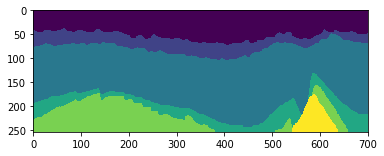

In [3]:
plt.imshow(labels[0,:,:].transpose())
plt.show()

In [39]:
class self_aug:
    def __init__(self, img, mask):
        self.image=img
        self.mask=mask
        self.labels=np.unique(mask)
        self.choise=None
        self.artificial_image=None
        
    def get_pair(self):
        self.choise = np.random.choice(np.unique(self.labels), size=(2,))
        self.layer_1 = self.mask == self.choise[0]
        self.layer_2 = self.mask == self.choise[1]
    
    def shuffle_mask(self):
        """
        change only labels
        :return: 
        """
        self.mask[self.layer_1] = self.choise[1]
        self.mask[self.layer_2] = self.choise[0]
        print(self.choise)
        
    def get_image_region(self, image, bool_mask):
        src1_mask = bool_mask.astype(self.image.dtype)#change mask to a 3 channel image 
        out= cv2.bitwise_and(image, src1_mask)
        out = self.bbox2(out)
        out = self.__fit_borders(out)
        out_mask = self.bbox2(src1_mask)
        out_mask = self.__fit_borders(out_mask)
        
        return out, out_mask
    
    def __fit_borders(self, cropped):
        self.im_height, self.im_width = self.image.shape[:2]
        self.arti_height, self.arti_width = cropped.shape[:2] 
        
        if self.arti_height < self.im_height or self.arti_width < self.im_width:
            clac_dif_h = self.im_height - self.arti_height
            clac_dif_w = self.im_height - self.arti_width
            ext_height = (int(clac_dif_h / 2))*10  if clac_dif_h > 0 else 0
            top, bottom = ext_height, ext_height
            ext_width = int(clac_dif_w / 2)*10 if clac_dif_w > 0 else 0
            left, right = ext_width, ext_width
            artificial_image = cv2.copyMakeBorder(cropped, top, bottom, left, right,
                                                       cv2.BORDER_REFLECT_101)
            print("artificial image_before", artificial_image.shape)
            artificial_image=artificial_image[:self.im_height, :self.im_width]
        if self.arti_height > self.im_height or self.arti_width > self.im_width:
            artificial_image = cropped[:self.im_height, :self.im_width]
        print("artificial image", artificial_image.shape)
        return artificial_image
    
    def bbox2(self,image):
        rows = np.any(image, axis=1)
        cols = np.any(image, axis=0)
        ymin, ymax = np.where(rows)[0][[0, -1]]
        xmin, xmax = np.where(cols)[0][[0, -1]]
        croped=image[ymin:ymax+1, xmin:xmax+1]
        return croped
    
    def shuffle_image(self):
        """
        change only mask
        :return: 
        """
        image_buf = self.image.copy()
        im1, mask_1=self.get_image_region(image_buf, self.layer_1)
        im2, mask_2=self.get_image_region(image_buf,self.layer_2)
        print(self.layer_1.shape, im1.shape, self.layer_2.shape, im2.shape)
        print(im1[self.layer_1].shape, self.image[self.layer_1].shape)
        self.image[self.layer_1] = im1[self.layer_1]
        self.image[self.layer_2] = im2[self.layer_2]
        self.mask[self.layer_1] = mask_1[self.layer_1]
        self.mask[self.layer_2] = mask_2[self.layer_2]
        

In [40]:
a= self_aug(img = data[0,:,:].transpose().copy(), mask=labels[0,:,:].transpose().copy())

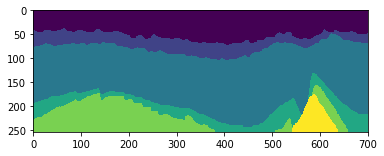

In [41]:
a.get_pair()
plt.imshow(a.mask)

artificial image_before (1874, 701)
artificial image (255, 701)
artificial image_before (1874, 701)
artificial image (255, 701)
artificial image_before (939, 701)
artificial image (255, 701)
artificial image_before (776, 701)
artificial image (255, 701)
(255, 701) (255, 701) (255, 701) (255, 701)
(37941,) (37941,)
[0 2]


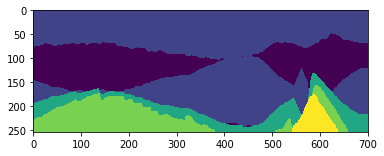

In [43]:
a.shuffle_image()
plt.imshow(a.mask)
print(a.choise)

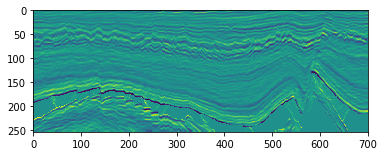

In [38]:
plt.imshow(a.image)

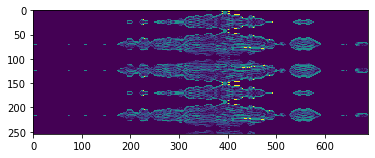

In [245]:
masked, out= a.get_image_region(a.image, a.layer_1)
plt.imshow(masked)

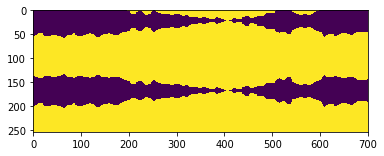

In [236]:
ou=out.astype("uint8")
plt.imshow(out.astype("uint8"))

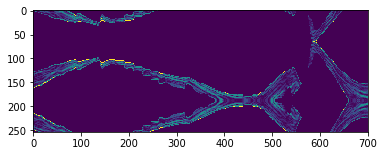

In [190]:
plt.imshow(a.artificial_image)

In [ ]:
out.dtype, a.image.dtype

In [8]:
p = '/media/nvme/data/projects/LithONet/data/LANDMASS/LANDMASS1/chaotic/chaotic_0001.mat'
data = scipy.io.loadmat(p)

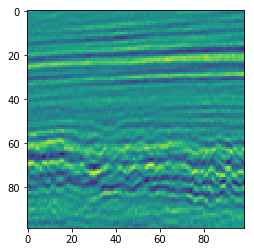

In [12]:
plt.imshow(data['img'])

In [21]:
dim=(128,128,128)
fx  = np.fromfile('/media/nvme/data/projects/LithONet/data/data2/validation/seis/10.dat',dtype=np.single)
fx = np.reshape(fx,dim)

In [22]:
fx.shape

(128, 128, 128)

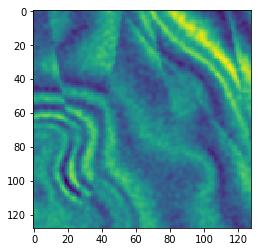

In [23]:
plt.imshow(fx[:,:,10])
plt.show()

In [1]:

from base import BaseDataSet, BaseDataLoader
from utils import palette
import numpy as np
import os
import scipy
import torch
from PIL import Image
import cv2
from torch.utils.data import Dataset
from torchvision import transforms

class NorwayDataset(BaseDataSet):
    def __init__(self, **kwargs):
        self.num_classes = 6
        self.palette = [0,0,255,255,0,0,0,255,0,255,255,255,255,0,255,0,255,255]
        super(NorwayDataset, self).__init__(**kwargs)

    def _set_files(self):
        if 'test' in self.split:
            self.root = os.path.join(self.root,'test_once','test1')
        elif 'val' in self.split:
            self.root = os.path.join(self.root,'test_once','test2')
        else:
            self.root = os.path.join(self.root,'train','train')
        self.files = np.load(self.root+'_seismic.npy')
        self.labels = np.load(self.root+'_labels.npy')
        self.files = np.load(self.root+'_seismic.npy')
        self.labels = np.load(self.root+'_labels.npy')
    
    def _load_data(self, index):
        return self.files[index], self.labela[index], str(index)

class NorwayAugDataset(BaseDataSet):
    def __init__(self, **kwargs):
        self.num_classes = 6
        self.palette = [0,0,255,255,0,0,0,255,0,255,255,255,255,0,255,0,255,255]
        super(NorwayAugDataset, self).__init__(**kwargs)

    def _set_files(self):
        if 'test' in self.split:
            self.root = os.path.join(self.root,'test_once','test1')
        elif 'val' in self.split:
            self.root = os.path.join(self.root,'test_once','test2')
        else:
            self.root = os.path.join(self.root,'train','train')
        self.files = np.load(self.root+'_seismic.npy')
        self.labels = np.load(self.root+'_labels.npy')
        self.files = np.load(self.root+'_seismic.npy')
        self.labels = np.load(self.root+'_labels.npy')
    
    def _load_data(self, index):
        return self.files[index].reshape((-1,-1,1)), self.labela[index], str(index)


class Norway(BaseDataLoader):
    def __init__(self, data_dir, batch_size, split, crop_size=None, base_size=None, scale=True, num_workers=1, val=False,
                    shuffle=False, flip=False, rotate=False, blur= False, augment=False, val_split= None, return_id=False):
        
        self.MEAN = [0]
        self.STD = [1.]

        kwargs = {
            'root': data_dir,
            'split': split,
            'mean': self.MEAN,
            'std': self.STD,
            'augment': augment,
            'crop_size': crop_size,
            'base_size': base_size,
            'scale': scale,
            'flip': flip,
            'blur': blur,
            'rotate': rotate,
            'return_id': return_id,
            'val': val
        }
    
        if split in ["train_aug", "trainval_aug", "val_aug", "test_aug"]:
            self.dataset = NorwayAugDataset(**kwargs)
        elif split in ["train", "trainval", "val", "test"]:
            self.dataset = NorwayDataset(**kwargs)
        else: 
            raise ValueError(f"Invalid split name {split}")
        super(NorwayDataLoader, self).__init__(self.dataset, batch_size, shuffle, num_workers, val_split)



/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [1]:
import os
import json
import argparse
import torch
import dataloaders
import models
import inspect
import math
from utils import losses
from utils import Logger
from utils.torchsummary import summary
from trainer import Trainer

def get_instance(module, name, config, *args):
    # GET THE CORRESPONDING CLASS / FCT 
    return getattr(module, config[name]['type'])(*args, **config[name]['args'])
    
config = json.load(open('config.json'))
# DATA LOADERS
train_loader = get_instance(dataloaders, 'train_loader', config)
val_loader = get_instance(dataloaders, 'val_loader', config)


/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
batch = train_loader.

TypeError: 'Norway' object does not support indexing